## Elementary Minflux Tracking Analysis code for Pablo (v1.0)

**Analysis code based on current (29/07/21) progression of analysis of SPT data by Francesco**

### Import libraries

In [2]:
import sys
sys.path.insert(0,'../..')

import trait2d.analysis as tr
import trait2d.analysis.minflux as mf
from trait2d.analysis.minflux import MFTrack, MFTrackDB, track_extractor
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from os import listdir,makedirs
import os
import json
import shutil
import pandas as pd
from trait2d.analysis import BIC #function that calculates the BIC, obviously
from scipy.optimize import curve_fit
from scipy.stats import kstest
plt.style.use('dark_background')

### Insert folder name and prints filenames to check

In [2]:
datafolder = '.' #Mind the separator. For windows it's \\. This we need to check together

os.chdir(datafolder)
folder = '.'

# get a filli
filelist = [entry for entry in listdir(folder) if entry.endswith('json')]
for (i,name) in zip(range(len(filelist)),filelist):
    print(i,'\t',name)

0 	 220531 m5-Ptk2-10pM_SR-PEG-Chol-640_10pc-hex-bgc50khz-dw100us-pht20.json


### Select file to analyze from the list above using the left-hand number

Tries to import the tracks from the file, prints how many tracks are present


In [4]:
#Preliminary parameters to select before import

min_length = 100       #the minimum number of localizations in a track in order to analize it

min_fr = 0             #minimum value of the average emission frequency (efo) of the track for it to be considered.

max_fr = np.inf        #maximum value of the average emission frequency of the track.
                       #Rationale is that if the frequency ecceeds some value, it then maybe more than one emitter. 

fac_time_diff = 50     #maximum time separation between two successive localizations for a track to be considered the same, 
                       #in terms of multiple of the minimum difference between two localizations
                       #factor of minimum time diff between two locs
                       #Rationale: maybe the particle is lost by the microscope, and a different one is then tracked.
                       #Put it at a very high value (es: 50) to ignore

In [4]:
which_file = 0 #selection from the list above

tab = track_extractor(os.path.join(folder, filelist[which_file]),minimum_length = min_length, min_frq = min_fr, max_frq = max_fr, factor_time_diff = fac_time_diff)

print(f'Imported {len(tab)} tracks!')

Imported 82 tracks!


### Sets up a summary table from which to quickly evaluate tracks

In [5]:
print('Track ID\tDuration(sec)\tNumber of localizations\tAverage EFO\tMedian time difference (sec)')
for track in tab:
    mddt = np.median([track['track']['t'].diff(1)[1:-1]])
    print(f"{track['tid']}\t\t{track['track']['t'].iloc[-1]-track['track']['t'].iloc[0]:.4f}\t\t{track['length']}\t\t\t{track['avg_frq']:.2f}\t{mddt:.2E}")


Track ID	Duration(sec)	Number of localizations	Average EFO	Median time difference (sec)
0		0.1490		431			120189.80	2.82E-04
1		0.0444		190			219140.19	1.50E-04
2		0.0744		277			202217.86	2.82E-04
3		0.0268		138			243165.87	1.50E-04
4		0.1026		413			209283.13	1.50E-04
5		0.0872		298			141338.21	2.82E-04
6		0.0363		175			245712.38	1.50E-04
7		0.2983		1045			149746.24	2.82E-04
8		0.0885		179			116438.60	2.82E-04
9		0.0523		141			110536.07	2.82E-04
10		0.1020		405			221795.87	1.50E-04
11		0.0309		155			220984.43	1.50E-04
12		0.0802		457			264359.91	1.50E-04
13		0.0532		142			111196.88	2.82E-04
14		0.0674		194			118339.99	2.82E-04
15		0.1465		333			98672.25	4.14E-04
16		0.2272		714			130985.33	2.82E-04
17		0.1098		248			98485.58	4.14E-04
18		0.0674		157			114886.65	2.82E-04
19		0.2473		1158			238442.96	1.50E-04
20		0.1390		672			264298.28	1.50E-04
21		0.1530		775			273084.91	1.50E-04
22		0.1399		666			223632.04	1.50E-04
23		0.0372		102			115000.62	2.82E-04
24		0.0667		230			185830.76	2.82E-

In [6]:
#get info on the track selected by the which_track variable
 
which_track = 27 #selects one of the tracks from the number printed above

if which_track<tab[-1]['tid']: 
    print('Track ID\tDuration(sec)\tNumber of localizations\tAverage EFO\tMedian time difference (sec)')
    mddt = np.median([tab[which_track]['track']['t'].diff(1)])    
    print(f"{tab[which_track]['tid']}\t\t{tab[which_track]['track']['t'].iloc[-1]-tab[which_track]['track']['t'].iloc[0]:.4f}\t\t{tab[which_track]['length']}\t\t\t{tab[which_track]['avg_frq']:.2f}\t{mddt:.2E}")
else:
    print('Track ID too large')


Track ID	Duration(sec)	Number of localizations	Average EFO	Median time difference (sec)
27		3.2161		4057			90870.39	NAN


### Import tracks into a Track Database object

In [5]:
Tracks_total = MFTrackDB.from_track_extractor(file = "",minimum_length = min_length, min_frq = min_fr, max_frq = max_fr, factor_time_diff = fac_time_diff)
Tracks_total = MFTrackDB(Tracks_total._tracks[:10])

Time to import!

Visualize all tracks in superimposition. The colormap indicates how much time has passed from the beginning of the track. All tracks are remapped to start at (0,0). 

Sorry, the time scale is still not working

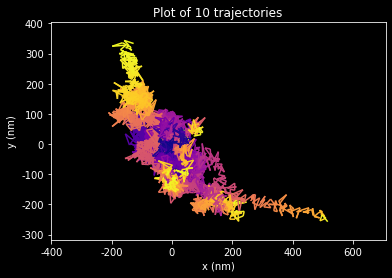

In [4]:
Tracks_total.plot_trajectories(cmap = 'plasma')

You can also do it track by track, just substitute the number below. And remember that Python starts from zero

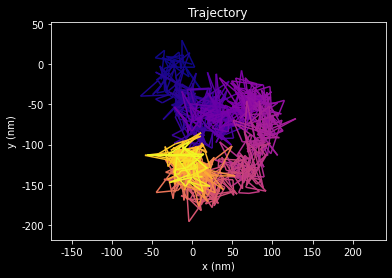

In [5]:
Tracks_total._tracks[4].plot_trajectory(cmap = 'plasma')

### Let's do some data analysis


Start by calculating MSD (can be lengthy)

In [6]:
from tqdm.notebook import trange
for i in trange(len(Tracks_total._tracks), desc = "Currently processing track No ..."): # len(Tracks_total._tracks)
    Tracks_total._tracks[i].MF_calculate_MSD()

Currently processing track No ...:   0%|          | 0/10 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/127 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/903 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/894 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/7612 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/206 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/1323 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/4929 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/23090 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/999 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/6008 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/142 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/978 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/248 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/919 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/187 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/504 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/247 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/2338 [00:00<?, ?it/s]

Spinning up MSD calculation ...:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating intervals ...:   0%|          | 0/156 [00:00<?, ?it/s]

Binning MSD ...:   0%|          | 0/1724 [00:00<?, ?it/s]

Set up blurring correction parameter R. 
// For full frame camera averaging, the value is R = 0.16666666666666
// Articles for MINFLUX, put it at 0.1 sometimes

This procedure is very liable to change depending on the outcomes of the study I am doing with Tobias. Put it at zero to get rid of it (discouraged). Also some other info is needed.

In [7]:
R_mf = 0.162      #Blurring correction for minflux. From Balzarotti 2017 (supplementary material, page 26/27) 
                    #0 assumes the localisation is perfect, i.e. no blurring.

percentage_points = 0.1 #in analysing with the MSD, we don't fit all the displacements, for mathematical reasons. 
                        #Maximum that one should fit is 25%. I usually keep myself at 10%
                        #Only the first 10-25% of the curve is fitted, because the later points have a high error.
    
enable_log_sampling = True #the most important points are at the beginning, not at the end of the MSD/ADC curve. 
                            #By sampling the curve logarithmically we emphasize them better
    
log_sampling_frequency = 0.1 #you can play with this parameter, but this usually works

weighing_method = 'error' #for the fit. You can also select 'disabled'

significance_value = 0.001  #yes this is a p value
                            #reject bad tracks based on the p value obtained from the Kolmogorov-Smirnov test 
                            #for qoodness of fit [0,1) 
                            #(Null Hypothesis is that fit and model are equivalent)

Also let's pre-calculate the ADC

In [8]:
for track in Tracks_total._tracks:
    track.MF_calculate_adc(R = R_mf)

Quickly plot some track in MSD and ADC

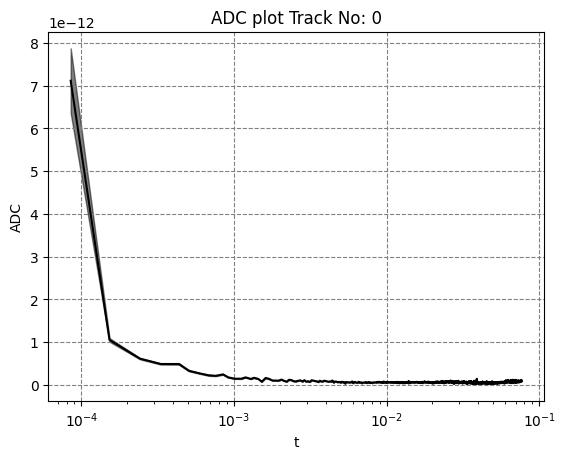

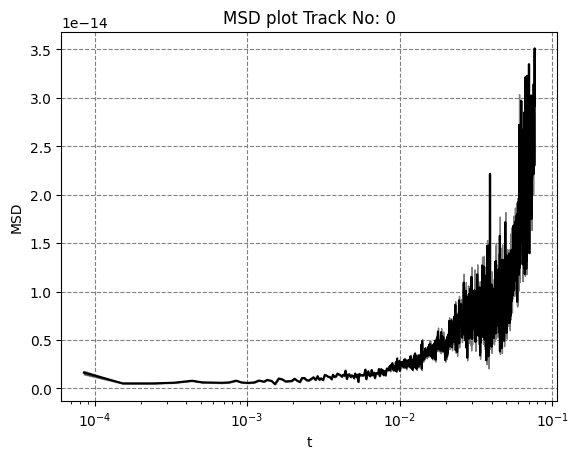

In [18]:
which_track = 0 #selects one of the tracks from the number printed above

plt.style.use('default')

if which_track<Tracks_total._tracks[-1]._id: 
    Tracks_total._tracks[which_track].plot_adc(min = 0, max = 1000)
    Tracks_total._tracks[which_track].plot_msd(min = 0, max = 1000)
else:
    print('Track ID too large')

### Now we want to do some analysis 

First, we define our database of models. The models herein are the base ones that come with the softwares. Additional ones can be defined in another moment

In [12]:
from trait2d.analysis import ModelDB
from trait2d.analysis.models import ModelBrownian, ModelConfined, ModelHop

if len(ModelDB().models) !=0:
    ModelDB().cleanup()


ModelDB().add_model(ModelBrownian)
ModelDB().add_model(ModelConfined)  
ModelDB().add_model(ModelHop)

Whereby:  
ModelBrownian is `D + delta**2 / (2*t*(1-2*R*dt/t))`  
ModelConfined is `D_micro * (tau/t) * (1 - np.exp(-t/tau)) + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))`  
ModelHop is `D_macro + D_micro * (tau/t) * (1 - np.exp(-t/tau)) + delta ** 2 / (2 * t * (1 - 2 * R * dt / t))`

To set initial values and bounds, we need to know the parameter order:  
for Brownian, it is: `D, delta`  
for Confined it is: `D_micro, delta, tau`  
for Hop it is: `D_macro, D_micro, delta, tau`  

Diffusion coefficients are in $m^2$$sec^-1$, tau is in seconds, delta is in meters.

Below a starting set of parameter that for me has worked in other situations, slightly modified for the occasion. The parameter tau is very dangerous: I would set the lowest value to twice the smallest time interval, and the highest value to no more than half the total time of the trajectory

In [13]:
#For Brownian motion

ModelDB().get_model(ModelBrownian).initial = [0.2E-12, 20E-9] #set initial guesses with the order as specified above
ModelDB().get_model(ModelBrownian).lower = [0.01E-12, 5E-9] #set lower bounds
ModelDB().get_model(ModelBrownian).upper = [2E-12, 40E-9] #set upper bounds

#for Confined, it is D_micro, delta, tau

ModelDB().get_model(ModelConfined).initial = [0.15E-12, 20E-9, 0.0005] #set initial guesses with the order as specified above
ModelDB().get_model(ModelConfined).lower = [0.005E-12, 5E-9, 0.0001] #set lower bounds
ModelDB().get_model(ModelConfined).upper = [0.5E-12, 40E-9, 0.001] #set upper bounds

#for Hop, it's D_macro, D_micro, delta, tau

ModelDB().get_model(ModelHop).initial = [0.15E-12, 0.15E-12, 20E-9, 0.001] #set initial guesses with the order as specified
ModelDB().get_model(ModelHop).lower = [0.01E-12, 0.005E-12, 5E-9, 0.0005] #set lower bounds
ModelDB().get_model(ModelHop).upper = [0.75E-12, 0.75E-12, 40E-9, 0.005] #set upper bounds

The following line does the fitting and best model selection based on Bayesian Information Criterion.
By pre-calculating MSD and ADC, this step is much much faster

Fit failed for the following tracks 

[1, 2]


c:\Users\belav\Documents\GitHub\FReina_TRAIT2D\Doodles\Pablo\../..\trait2d\analysis\minflux\__init__.py:971: UserWarning: ADC analysis failed for 2/10 tracks. Consider raising the maximum function evaluations using the maxfev keyword argument. To get a more detailed stacktrace, run the ADC analysis for a single track.
  warnings.warn("ADC analysis failed for {}/{} tracks. "


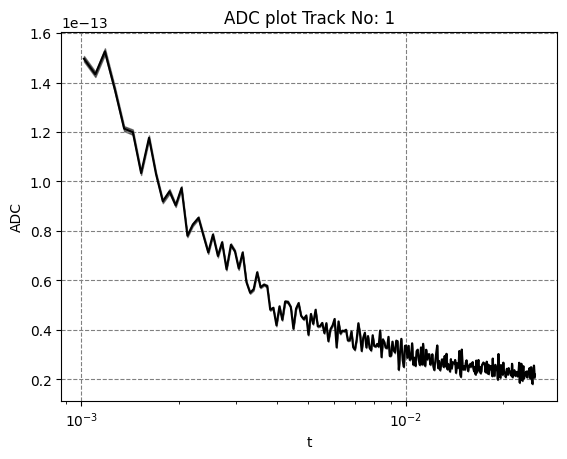

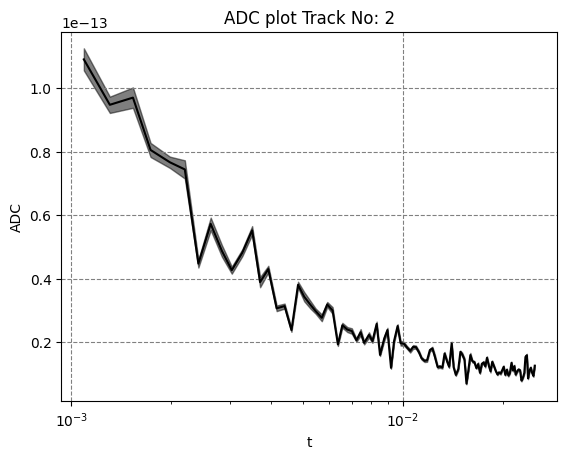

In [14]:
_failed = Tracks_total.adc_analysis(R = R_mf, 
                                    fraction_fit_points = percentage_points, 
                                    maxfev = 3000, 
                                    enable_log_sampling = enable_log_sampling, 
                                    log_sampling_dist = log_sampling_frequency, 
                                    weighting = weighing_method)

#If there are any failed fits, it prints for which tracks it has failed

if _failed:
    print('Fit failed for the following tracks \n')
    print(_failed)

#plot the trajectories for which the fit has failed to look if they are funny and it is justified
for i in _failed:
    Tracks_total._tracks[i].plot_adc()

The following is the least efficient way possible to check for any tracks that do not respect the goodness of fit metric that I discussed above.

In [15]:
goodtrack_idxs = []

for i in range(len(Tracks_total._tracks)):
    if i not in _failed:
        mod = Tracks_total._tracks[i]._adc_analysis_results['best_model']
        if Tracks_total._tracks[i].get_adc_analysis_results()['fit_results'][mod]['KStestPValue'] < significance_value:
            print(f"bad fit for track {i} with p-value {DivTracks_db._tracks[i].get_adc_analysis_results()['fit_results'][DivTracks_db._tracks[i].get_adc_analysis_results()['best_model']]['KStestPValue']}")
        else:
            goodtrack_idxs.append(i)
    
if goodtrack_idxs:
    print('Goodness-of-fit test passed for the following tracks:')
    print(goodtrack_idxs)

good_tracks = MFTrackDB([Tracks_total._tracks[i] for i in range(len(Tracks_total._tracks)) if i in goodtrack_idxs])

print(f'\n The new database contains {len(good_tracks._tracks)} trajectories')

Goodness-of-fit test passed for the following tracks:
[0, 3, 4, 5, 6, 7, 8, 9]

 The new database contains 8 trajectories


## Also plot the track parameters for "good tracks" (summary statistics)

Extract the parameters obtained from the fitting routine of the best model found by the statistical procedure through Bayesian Information Criterion

In [16]:
select_track = 5

model = good_tracks._tracks[select_track]._adc_analysis_results['best_model']
print(f'The selected track is best described by the {model} model of diffusion')

good_tracks._tracks[select_track]._adc_analysis_results['fit_results'][model]

The selected track is best described by the ModelBrownian model of diffusion


{'params': array([1.71098231e-13, 1.42330672e-08]),
 'errors': array([1.11357118e-15, 3.95303768e-11]),
 'bic': -768.2787351937598,
 'KSTestStat': 0.23076923076923078,
 'KStestPValue': 0.8978057035171046,
 'rel_likelihood': 1.0}

I realize the above is tedious, uncomment the following to have it printed out on the screen for all tracks (will be long, apologies)

In [17]:
for track in good_tracks._tracks:
    model = track._adc_analysis_results['best_model']
    print(f'Best Model: {model}')
    print(track._adc_analysis_results['fit_results'][model])

Best Model: ModelBrownian
{'params': array([4.56167163e-14, 1.62367830e-08]), 'errors': array([1.55237752e-15, 8.66253794e-11]), 'bic': -817.2170939433324, 'KSTestStat': 0.13333333333333333, 'KStestPValue': 0.9997887537139585, 'rel_likelihood': 1.0}
Best Model: ModelHop
{'params': array([1.30873622e-14, 2.40237593e-14, 1.60856807e-08, 5.00000000e-03]), 'errors': array([6.17769450e-18, 6.27697290e-17, 2.39403174e-12, 1.97593155e-05]), 'bic': -1796.3313397293825, 'KSTestStat': 0.10344827586206896, 'KStestPValue': 0.9984782925008956, 'rel_likelihood': 1.0}
Best Model: ModelConfined
{'params': array([1.65632655e-13, 1.28194932e-08, 1.00000000e-03]), 'errors': array([3.85043132e-15, 7.50137738e-11, 1.61121267e-05]), 'bic': -1471.4138246488292, 'KSTestStat': 0.20833333333333334, 'KStestPValue': 0.686017125117228, 'rel_likelihood': 1.0}
Best Model: ModelConfined
{'params': array([1.52125933e-14, 1.88919199e-08, 1.05524321e-04]), 'errors': array([3.13989243e-12, 3.96844615e-09, 1.48204714e-02]

Unfortunately the plotting functions are not ready at this point, but we can cook something up. This works with the "select_track" parameter from above

(0.0, 0.034805158823528866)

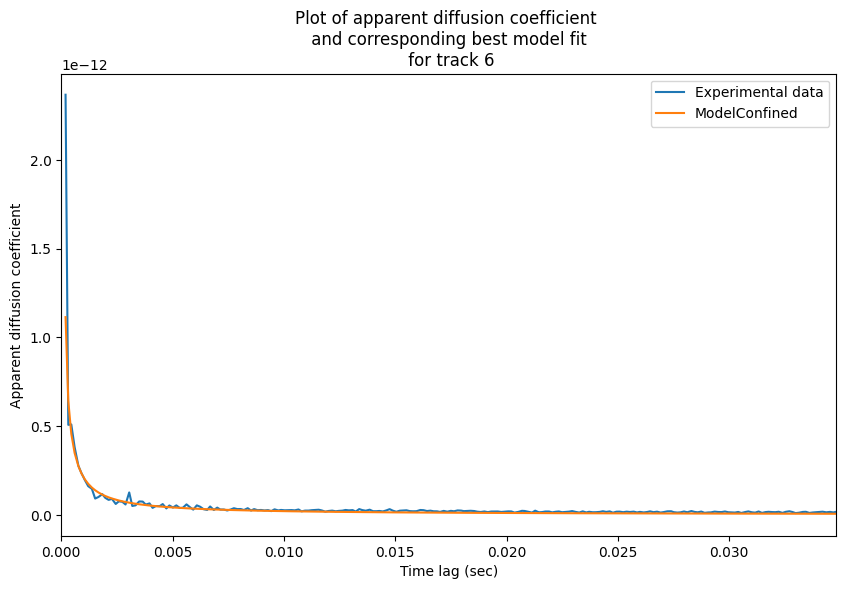

In [24]:
import matplotlib.pyplot as plt

select_track = 6

target = good_tracks._tracks[select_track]

plt.figure(figsize = (10,6))
plt.plot(target._tn,target._adc)
for m in ModelDB().models:
    if m.__class__.__name__ == model:
        plt.plot(target._tn,m(target._tn,*target._adc_analysis_results['fit_results'][model]['params']))
        plt.legend(('Experimental data',model))
plt.ylabel('Apparent diffusion coefficient')
plt.xlabel('Time lag (sec)')
plt.title(f'Plot of apparent diffusion coefficient \n and corresponding best model fit \n for track {select_track}')
plt.xlim([0,target._tn[round(percentage_points*len(target._tn))]])
        

### Printing 'good_tracks' fit parameters

In [27]:
## Sorting by best model

sort_key = {'ModelBrownian':[], "ModelConfined":[], "ModelHop":[]}

for track in good_tracks._tracks:
    sort_key[track._adc_analysis_results['best_model']].append(track)
    
## Histogram action

for key in sort_key.keys():
    
    print('Best model: ' + key +"\n")
    if (key == 'ModelBrownian') & (len(sort_key[key]) != 0) :
        print('Track ID\tD [m²/s]\t$\delta$ [m]')
    
        for track in sort_key[key]:
            print("{}\t\t{:.5g}\t{:.5g}".format(track.get_id(), track.get_adc_analysis_results()['fit_results'][key]['params'][0], track.get_adc_analysis_results()['fit_results'][key]['params'][1]))
            
        
    elif (key == 'ModelHop') & (len(sort_key[key]) != 0) :
        print('Track ID\tD_M [m²/s]\tD_mu [m²/s]\ttau [s]\t\delta [m]')
    
        for track in sort_key[key]:
            res = track.get_adc_analysis_results()['fit_results'][key]['params']
            print("{}\t\t{:.5g}\t{:.5g}\t{:.5g}\t{:.5g}".format(track.get_id(), res[0], res[1], res[3], res[2]))
            
    
    elif (key == 'ModelConfined') & (len(sort_key[key]) != 0) :
        print('Track ID\tD_mu [m²/s]\ttau [s] \t\delta [m]')
    
        for track in sort_key[key]:
            res = track.get_adc_analysis_results()['fit_results'][key]['params']
            print("{}\t\t{:.5g}\t{:.5g}\t\t{:.5g}".format(track.get_id(), res[0], res[2], res[1]))
            
    else:
        print("\n No track was categorized to be " + key +"\n")        
    
    print("------------------------------------------------------------------------------")

Best model: ModelBrownian

Track ID	D [m²/s]	$\delta$ [m]
0		4.5617e-14	1.6237e-08
6		2.4833e-13	1.2568e-08
7		1.711e-13	1.4233e-08
8		1.173e-14	1.7507e-08
------------------------------------------------------------------------------
Best model: ModelConfined

Track ID	D_mu [m²/s]	tau [s] 	\delta [m]
4		1.6563e-13	0.001		1.2819e-08
5		1.5213e-14	0.00010552		1.8892e-08
9		9.4119e-14	0.001		1.2052e-08
------------------------------------------------------------------------------
Best model: ModelHop

Track ID	D_M [m²/s]	D_mu [m²/s]	tau [s]	\delta [m]
3		1.3087e-14	2.4024e-14	0.005	1.6086e-08
------------------------------------------------------------------------------


### Printing 'good_tracks' data

### Do you want to delete any tracks from 'good_tracks' ?

In [22]:
## Potential Popping
to_be_deleted = [] # List to enter the track IDs for deletion

if to_be_deleted != []:
    good_tracks.pop_tracks(to_be_deleted)
    
    print("The following tracks have succefully been deleted from 'good_tracks': {}".format(to_be_deleted))

else:
    print("No tracks have been deleted!")

No tracks have been deleted!


In [28]:
def calc_bins(array:np.ndarray, return_diff:bool = False, ceil:bool = True):
    diff = np.abs(np.diff(array, axis=0, n = 1))
    diff[diff == 0] = np.infty
    diff = np.min(diff, axis = 0)
    bins = np.max(array, axis = 0) - np.min(array, axis = 0)
    bins = np.divide(bins, diff)
    
    if ceil:
        bins = np.ceil(bins).astype(int) * 2
    
    if return_diff:
        return bins, diff
    else:
        return bins

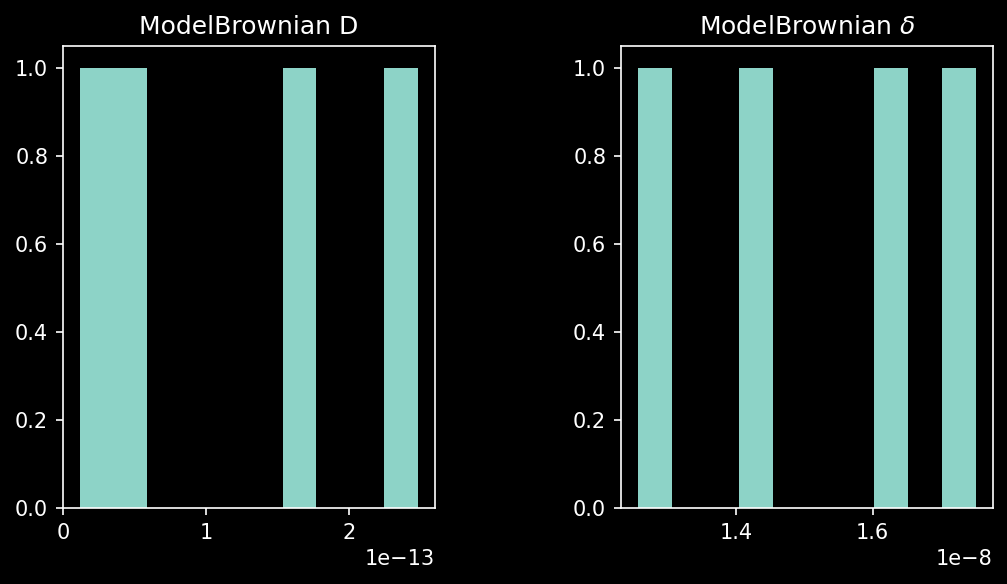

In [39]:
## ModelBrownian
plt.style.use('dark_background')
Key = 'ModelBrownian'

try:
    tmp_param = []
    for track in sort_key[Key]:
        tmp_param.append(track.get_adc_analysis_results()['fit_results'][Key]['params'])
    tmp_param = np.vstack(tmp_param)
    
    bins = calc_bins(tmp_param)
    
    try:    
        bins = calc_bins(tmp_param)
    except:
        bins = np.array([10,10])
        
    bins[bins<=10] = 10

    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4), dpi = 150)
    plt.subplots_adjust(wspace = 0.5)
    ax1.hist(tmp_param[:,0], bins = bins[0])
    ax1.set_title('ModelBrownian D')

    ax2.hist(tmp_param[:,1], bins = bins[1])
    ax2.set_title('ModelBrownian $\delta$')
except:
    print('No tracks with best model being ModelBrownian!')

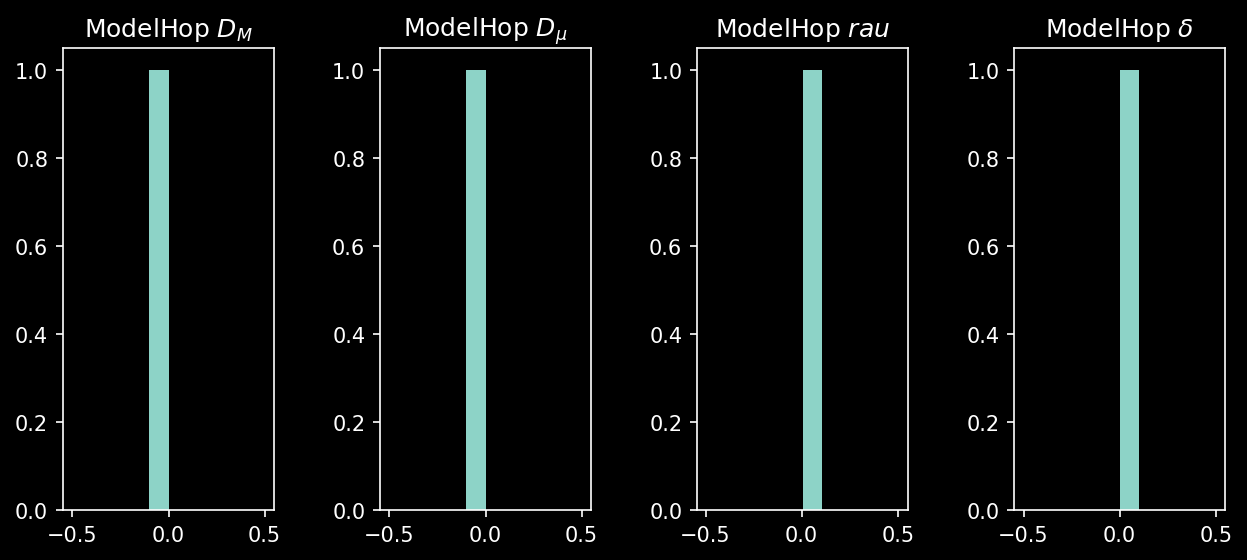

In [40]:
## ModelHop
plt.style.use('dark_background')
Key = 'ModelHop'

try:
    tmp_param = []
    for track in sort_key[Key]:
        tmp_param.append(track.get_adc_analysis_results()['fit_results'][Key]['params'])

    tmp_param = np.vstack(tmp_param)
    
    try:    
        bins = calc_bins(tmp_param)
    except:
        bins = np.array([10,10,10,10])
        
    bins[bins<=10] = 10

    fig, (ax1,ax2, ax3, ax4) = plt.subplots(1,4, figsize = (10,4), dpi = 150)
    plt.subplots_adjust(wspace = 0.5)
    ax1.hist(tmp_param[:,0], bins = bins[0])
    ax1.set_title('ModelHop $D_M$')

    ax2.hist(tmp_param[:,1], bins = bins[1])
    ax2.set_title('ModelHop $D_\mu$')

    ax3.hist(tmp_param[:,3], bins = bins[3])
    ax3.set_title('ModelHop $r\tau$')

    ax4.hist(tmp_param[:,2], bins = bins[2])
    ax4.set_title('ModelHop $\delta$')
except:
    print('No tracks with best model being ModelHop!')

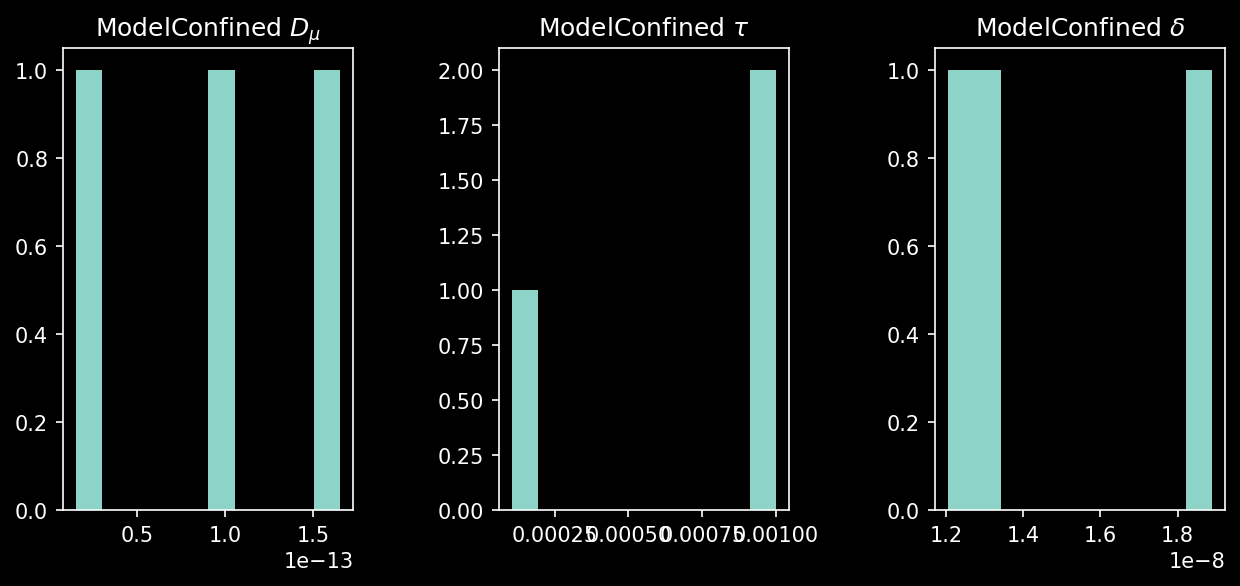

In [33]:
## ModelConfined
plt.style.use('dark_background')
Key = 'ModelConfined'
try:
    tmp_param = []
    for track in sort_key[Key]:
        tmp_param.append(track.get_adc_analysis_results()['fit_results'][Key]['params'])
    tmp_param = np.vstack(tmp_param)
    
    bins = calc_bins(tmp_param)
    
    try:    
        bins = calc_bins(tmp_param)
    except:
        bins = np.array([10,10,10])
    
    bins[bins<=10] = 10

    fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (10,4), dpi = 150)
    plt.subplots_adjust(wspace = 0.5)
    ax1.hist(tmp_param[:,0], bins = bins[0])
    ax1.set_title('ModelConfined $D_\mu$')

    ax2.hist(tmp_param[:,2], bins = bins[2])
    ax2.set_title(r'ModelConfined $\tau$')

    ax3.hist(tmp_param[:,1], bins = bins[1])
    ax3.set_title('ModelConfined $\delta$')
except:
    print('No tracks with best model being ModelConfined!')

### Localization imprecision correction

In [57]:
## Search for largest track
l = []
for track in good_tracks._tracks:
    l.append((track._t.shape[0],track._id))
    
print("Track with ID {} is the largest of 'good_tracks'.".format(max(l)[1]))

Track with ID 27 is the largest of 'good_tracks'.


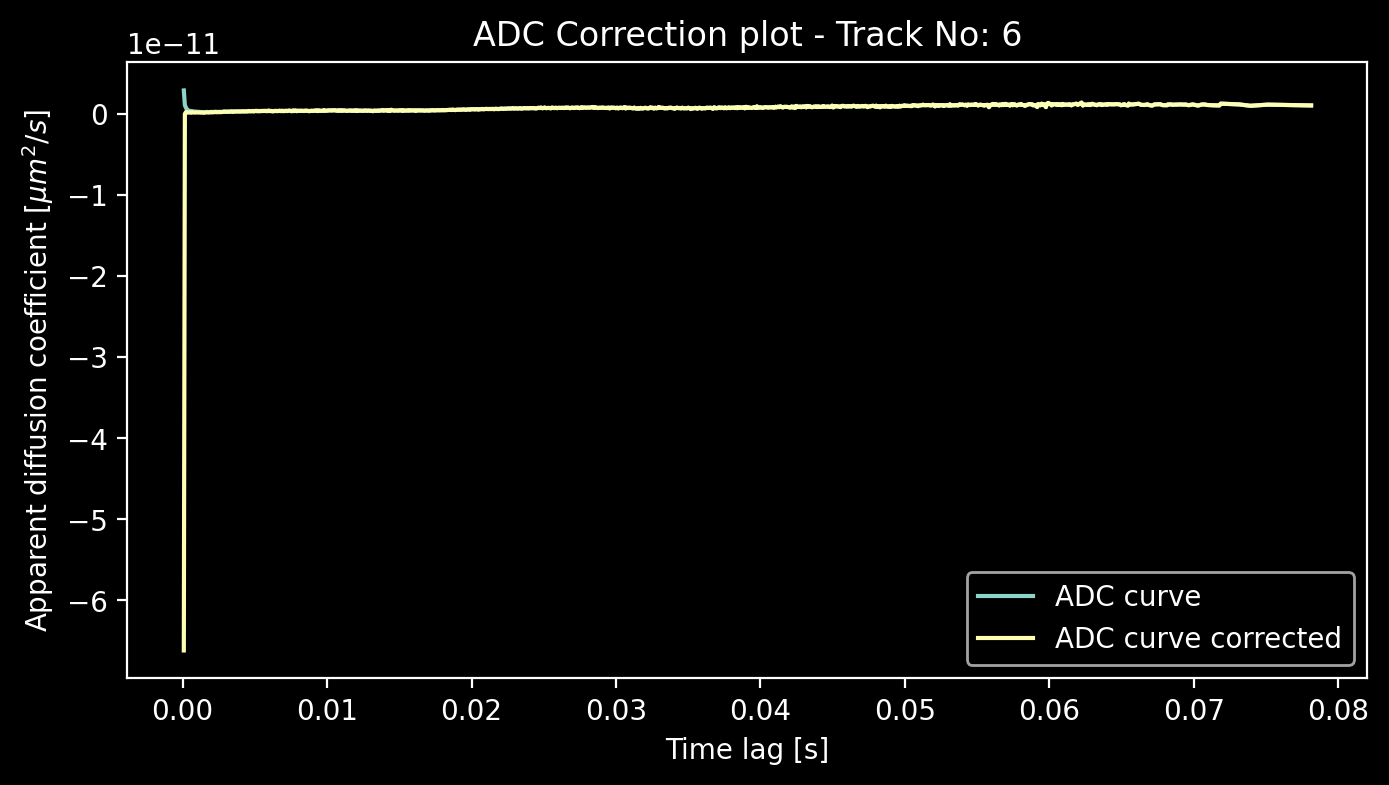

In [36]:
## Loc impress

Which_track:int = 6
current_track = good_tracks.get_track_by_id(Which_track)
Key = current_track._adc_analysis_results['best_model']

input_key = {'ModelBrownian':ModelDB().get_model(ModelBrownian)(current_track._tn, 0, current_track._adc_analysis_results['fit_results']['ModelBrownian']['params'][1]),
             'ModelHop':ModelDB().get_model(ModelHop)(current_track._tn, 0, 0, current_track._adc_analysis_results['fit_results']['ModelHop']['params'][2], 0),
             'ModelConfined':ModelDB().get_model(ModelConfined)(current_track._tn, 0, current_track._adc_analysis_results['fit_results']['ModelConfined']['params'][1], 0)}

correction = current_track._adc - input_key[Key]

plt.figure(figsize = (8,4), dpi = 200)
plt.title("ADC Correction plot - Track No: "+str(current_track._id))
plt.plot(current_track._tn, current_track._adc, label = "ADC curve")
plt.plot(current_track._tn, correction, label = "ADC curve corrected")

plt.xlabel("Time lag [s]")
plt.ylabel("Apparent diffusion coefficient [$\mu m^2/s$]")

plt.legend(loc = 'best', fancybox = True)